# Polynomial model fit

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import pandas as pd
import glob
import os
import math
import importlib
%matplotlib inline

import amaizeing_utils as maize

In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ejam/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

## Wrangle the input file

Load the data file

In [51]:
src = '../2019_G2F_Shared/'
data = pd.read_excel(src + '2019GXEleaf_angle.xlsx', engine='openpyxl')
data.replace(['90+', '90++'], 90, inplace=True)
print(data.shape)
data.head()

(500, 30)


,Unnamed: 0,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,LPlant.L1.End.Angle,...,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle,RPlant.L2.End.Angle,RPlant.L2.End.Length,RPlant.L2.Mid.Angle,RPlant.L2.Mid.Length,RPlant.L2.Stem.Angle
0,1,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,60.0,...,65.0,58.0,55.0,66.0,26.0,90.0,46.0,50.0,47.0,31.0
1,2,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,45.0,...,53.0,59.0,33.0,63.0,23.0,75.0,43.0,43.0,48.0,15.0
2,3,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,65.0,...,61.0,62.0,48.0,70.0,25.0,43.0,46.0,33.0,65.0,27.0
3,4,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,70.0,...,75.0,52.0,54.0,58.0,23.0,85.0,69.0,48.0,49.0,33.0
4,5,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,90.0,...,64.0,48.0,45.0,60.0,20.0,90.0,45.0,52.0,39.0,29.0


Separate the metadata from the measurements themselves

In [3]:
meta = data.iloc[:, 1:9]
meta.head()

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN


This file contains actually measurements from four different plants. Identify the column number where a different plant starts

In [4]:
endAngle = []
for i,name in enumerate(data.columns):
    if "End.Angle" in name:
        print('{}:\t{}'.format(i,name))
        endAngle.append(i)

9:	LPlant.L1.End.Angle
14:	LPlant.L2.End.Angle
20:	RPlant.L1.End.Angle
25:	RPlant.L2.End.Angle


Get the five different measures for a plant
- Three angles with respect to the stem
- Two distances from the base

In [34]:
bladeset = 3

numbers = data.iloc[:, endAngle[bladeset]:(endAngle[bladeset]+5)].dropna(axis='index', how='any')
print(numbers.shape)

numbers = numbers.loc[(numbers.iloc[:,2] != 90) & (numbers.iloc[:,4] != 90)]

#numbers = numbers[numbers[data.columns[endAngle[bladeset]]] != 90]

print(numbers.shape)
#numbers.iloc[65]
numbers.head()

(492, 5)
(492, 5)


,RPlant.L2.End.Angle,RPlant.L2.End.Length,RPlant.L2.Mid.Angle,RPlant.L2.Mid.Length,RPlant.L2.Stem.Angle
0,90.0,46.0,50.0,47.0,31.0
1,75.0,43.0,43.0,48.0,15.0
2,43.0,46.0,33.0,65.0,27.0
3,85.0,69.0,48.0,49.0,33.0
4,90.0,45.0,52.0,39.0,29.0


Concatenate the metadata with the information specific of this side of the plot. 

In [35]:
plotname = '_'.join(data.columns[endAngle[bladeset]].split('.')[:2])
print(plotname)
PlotData = pd.concat([meta, numbers], axis=1, join='inner')
PlotData.head()

RPlant_L2


,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L2.End.Angle,RPlant.L2.End.Length,RPlant.L2.Mid.Angle,RPlant.L2.Mid.Length,RPlant.L2.Stem.Angle
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,90.0,46.0,50.0,47.0,31.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,75.0,43.0,43.0,48.0,15.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,43.0,46.0,33.0,65.0,27.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,85.0,69.0,48.0,49.0,33.0
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,90.0,45.0,52.0,39.0,29.0


Separate the columns that measure angles from the columns that measure distances.

In [36]:
lengthCols = [1, 3]
angleCols = [0, 2, 4]

In [37]:
degs = np.flip(np.array(numbers.drop(columns=numbers.columns[lengthCols]), 
                        dtype=np.float), axis=1)
lengths = np.flip(np.array(numbers.drop(columns=numbers.columns[angleCols]), 
                        dtype=np.float), axis=1)

## Fit two simple polynomials, one going upwards, other downwards

### Shower thoughts

$$f_{\text{base to apex}}(x) = A_1(x-B)^{N_1} + C$$
$$g_{\text{apex to tip}}(x) = A_2(x-B)^{N_2} + C$$

- The problem is to find $A_1,A_2,B,C,N_1,N_2$ adequate.
- ~~Main issue is that $N$ must be a natural number.~~
- ~~This is usually not the case when solving the equation.~~
- ~~Use $\lceil N\rceil$ (ceil) or $\lfloor N\rfloor$ (floor) instead.~~ 


Inspired by the following

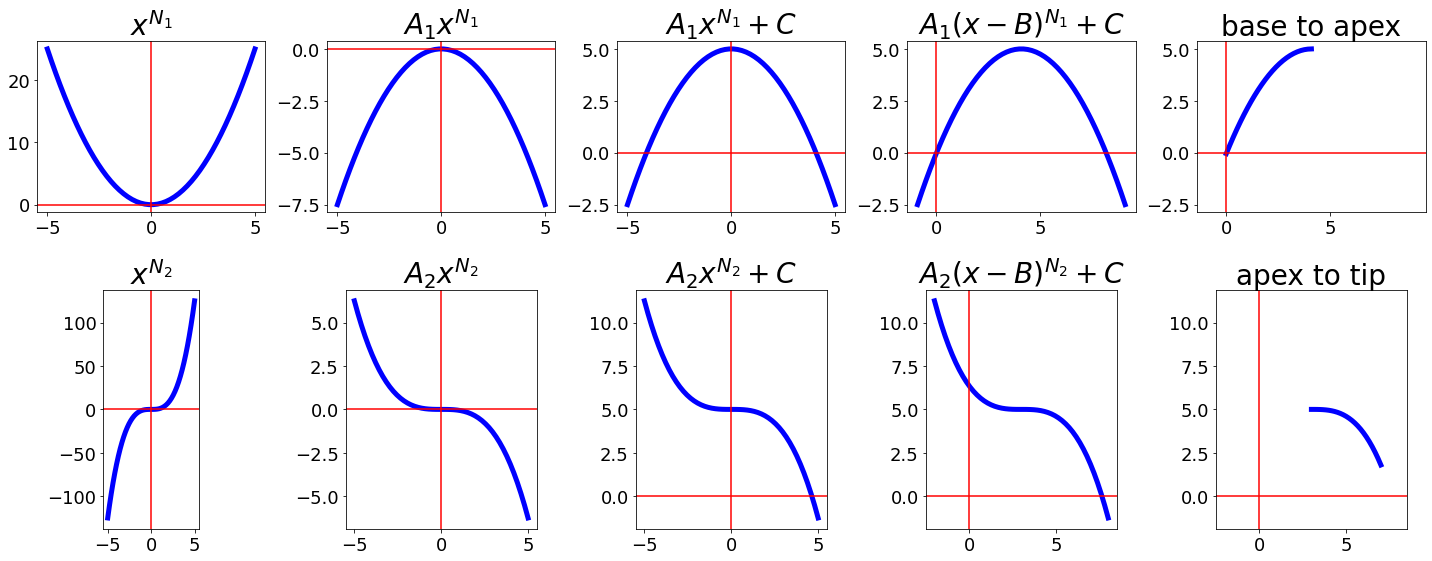

In [18]:
maize.shower_thought()

## Main problem: we don't know the angle formed by the tip of the leaf dangling.

- We can solve easily the first half: from base to top.
    - We know the angle formed by the base of the leaf with the stem
    
- We do not have an extra angle measure when it comes to the tip
    - We initially that the leaf dangles with the same angle as the one between the base and the stem.
    - Then we correct that angle if the the resulting polynomial model is too steep (low $N_2$) or too flat (high $N_2$)
    - We make sure the new $N_2$ is similar to $N_1$, so the curve appear smooth.
- We also limit possible values to $1.0\leq N_1 \leq 2.25$. Any values higher than that would produce curves that look too flat or too steep.

In [38]:
importlib.reload(maize)
idx = 81

deg = np.sort(degs[idx])
length = lengths[idx]
deg = 90 - deg
if deg[0] > 89:
    deg[0] = 89
print(deg)
print(length)

#wblade, wparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=True)
#ublade, uparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=False)

blade, params, downcurl = maize.poly_blade_fit(deg, length, 100, True)
print('downcurl: ', downcurl)
#dblade, dparams, _ = maize.poly_blade_fit(deg, length, 100, dangle_correction=False)

[70. 60. 25.]
[51. 53.]
downcurl:  False


	Model:	poly dangle tweak
Up::::	A = 2.59e-01	N = 1.59
Down::	B = -3.26e-01	M = 1.35
--------
a = 25.50	c = 44.17
b = 48.03	d = 22.40
-------


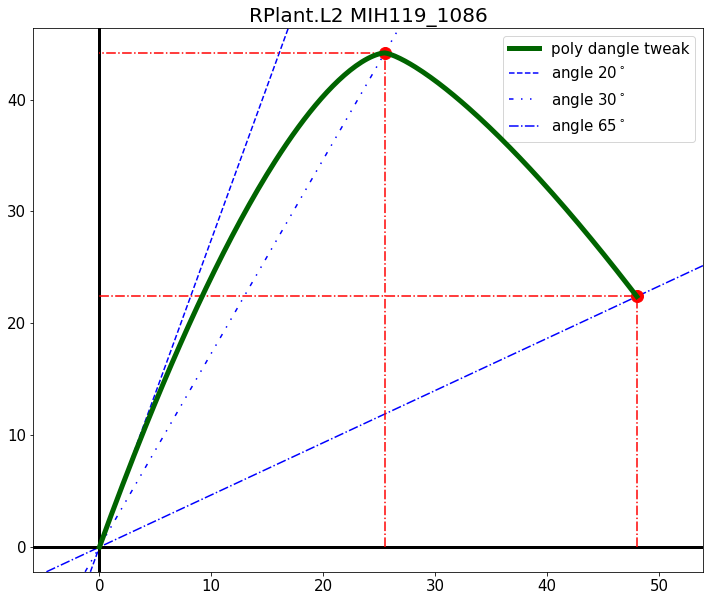

In [39]:
importlib.reload(maize)
title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
maize.plot_poly_blade([blade], deg, 
                      [params], title=title, 
                      labels=['poly dangle tweak'], 
                      verbose=True)

In [40]:
dst = '../model/' + plotname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
print(dst)

../model/RPlant_L2/


In [41]:
importlib.reload(maize)
idx = 12

for idx in range(0,len(degs)):
    deg = np.sort(degs[idx])
    length = lengths[idx]
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    blade, params, _ = maize.poly_blade_fit(deg, length, 100)
    title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
    maize.plot_poly_blade([blade], deg, 
                          [params], title=title, 
                          labels=['poly dangle tweak'], 
                          writefig=True, dst=dst, dpi=72)

/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:673: RuntimeWarning: divide by zero encountered in power
  poly = A*np.power(np.abs(x-a), N) + c
/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:675: RuntimeWarning: invalid value encountered in add
  poly = -np.flip(poly) + poly[0] + poly[-1]


## 

## Compute the polynomial coefficients for the rest of leaves

In [42]:
importlib.reload(maize)
resol = 100
Params= np.empty((len(degs), 8))
NormBlade = []
Extra = np.empty((len(degs), 4))

for idx in range(len(degs)):
    deg = np.sort(degs[idx])
    length = lengths[idx]
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    blade, params, down_curled = maize.poly_blade_fit(deg, length, resol)
    b, up, dw = maize.blade_lengths(blade, resol, down_curled)
    
    Params[idx,:] = params
    Extra[idx, :] = b, up, dw, down_curled

/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:673: RuntimeWarning: divide by zero encountered in power
  poly = A*np.power(np.abs(x-a), N) + c
/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:675: RuntimeWarning: invalid value encountered in add
  poly = -np.flip(poly) + poly[0] + poly[-1]
/home/ejam/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


## Save the coefficients in a CSV

In [43]:
dst = '../model/'
param_df = pd.DataFrame(np.column_stack((Params,Extra)), 
                        index=PlotData.index, 
                        columns=['A1','N1','A2','N2','a','b','c','d','total_blade_length', 'upblade_length', 'downblade_length', 'curled'])
df = pd.concat([PlotData, param_df], axis=1, join='inner')
df.to_csv(dst + plotname + '_poly_model.csv', index=True)
df

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L2.End.Angle,RPlant.L2.End.Length,...,A2,N2,a,b,c,d,total_blade_length,upblade_length,downblade_length,curled
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,90.0,46.0,...,-0.466463,1.811670,36.004089,46.000000,30.211018,0.000000,81.428066,48.962490,32.465576,0.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,75.0,43.0,...,-0.230515,2.135762,32.735921,41.534811,35.104978,11.129219,77.331241,50.881697,26.449544,0.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,43.0,46.0,...,0.000000,0.000000,35.401537,31.371925,54.513587,33.642270,65.411666,65.411666,0.000000,1.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,85.0,69.0,...,-0.158043,1.476587,36.414096,68.737434,32.787400,6.013746,93.023215,50.399049,42.624166,0.0
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,90.0,45.0,...,-0.104201,2.046635,30.732419,45.000000,24.010798,0.000000,70.265665,41.061888,29.203778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,MIH119_2246,11,19,2,PHW65_MoG_0633/PHT69,PHW65_MoG_0633/PHT69,WIPV17/31195,1.0,90.0,49.0,...,-0.119112,2.002036,36.531267,49.000000,18.613610,0.000000,65.879207,42.459299,23.419908,0.0
496,MIH119_2247,10,19,2,PHW65_MoG_0651/PHT69,PHW65_MoG_0651/PHT69,WIPV17/31196,1.0,90.0,41.0,...,-0.641405,1.489044,28.284271,41.000000,28.284271,0.000000,72.637119,41.234010,31.403108,0.0
497,MIH119_2248,9,19,2,PHW65_MoG_0660/PHT69,PHW65_MoG_0660/PHT69,WIPV17/31197,1.0,80.0,50.0,...,-0.326184,1.476748,29.568230,49.240388,35.238044,8.682409,81.020064,47.419719,33.600346,0.0
498,MIH119_2249,8,19,2,PHW65_MoG_0662/PHT69,PHW65_MoG_0662/PHT69,WIPV17/31198,1.0,90.0,57.0,...,-0.098002,1.794356,35.223538,57.000000,24.663787,0.000000,78.754009,44.698162,34.055847,0.0


# Load and merge the data

In [71]:
polymodel_files = sorted(glob.glob('../model/*poly_model.csv'))
data = [None for i in range(len(polymodel_files))]
for i in range(len(polymodel_files)):
    data[i] = pd.read_csv(polymodel_files[i], index_col='Unnamed: 0')
    data[i] = data[i].iloc[np.all(data[i].iloc[:, [8,10,12]].values < 91, axis=1)]

In [78]:
for i in range(len(data[0].columns)):
    print(i,data[0].columns[i], sep='\t')

0	plot
1	Pass
2	Range
3	Rep
4	New_Pedigree
5	Old_Pedigree
6	Old_Source
7	Shared
8	LPlant.L1.End.Angle
9	LPlant.L1.End.Length
10	LPlant.L1.Mid.Angle
11	LPlant.L1.Mid.Length
12	LPlant.L1.Stem.Angle
13	A1
14	N1
15	A2
16	N2
17	a
18	b
19	c
20	d
21	total_blade_length
22	upblade_length
23	downblade_length
24	curled


In [94]:
resol = 100
XRange = []
UPxrange = []
DWxrange = []

BLade = []
UPblade = []
DWblade = []

for idx in range(len(data)):
    Xrange = np.empty((len(data[idx]), 2*resol))
    Upxrange = np.empty((len(data[idx]), resol))
    Dwxrange = Upxrange.copy()
    
    Blade = np.empty((len(data[idx]), 2*resol))
    Upblade = np.empty((len(data[idx]), resol))
    Dwblade = Upblade.copy()
    
    for i in range(len(data[idx])):

        A,N,B,M, a,b,c,d = data[idx].iloc[i, 13:21].values
        down_curled = data[idx].iloc[i,-1]

        upxrange = np.linspace(0, a, resol)
        blade_up = maize.polycurve_up(upxrange, A, N, a, c)

        if not down_curled:
            dwxrange = np.linspace(a,b,resol)
            blade_dw = maize.polycurve_dw(dwxrange, B, M, a, c)

        else:
            dwxrange = np.zeros(len(upxrange)) + upxrange[-1]
            blade_dw = np.zeros(len(upxrange)) + blade_up[-1]

        xrange = np.hstack((upxrange, dwxrange))
        blade = np.hstack((blade_up, blade_dw))
        
        Xrange[i] = xrange
        Upxrange[i] = upxrange
        Dwxrange[i] = dwxrange
        
        Blade[i] = blade
        Upblade[i] = blade_up
        Dwblade[i] = blade_dw
        
    XRange.append(Xrange)
    UPxrange.append(Upxrange)
    DWxrange.append(Dwxrange)
    
    BLade.append(Blade)
    UPblade.append(Upblade)
    DWblade.append(Dwblade)

/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:673: RuntimeWarning: divide by zero encountered in power
  poly = A*np.power(np.abs(x-a), N) + c
/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:675: RuntimeWarning: invalid value encountered in add
  poly = -np.flip(poly) + poly[0] + poly[-1]


NameError: name 'curled' is not defined

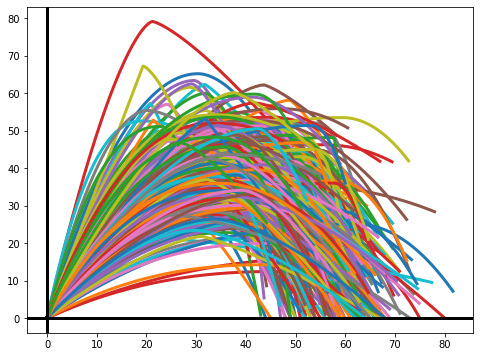

In [106]:
plt.figure(figsize=(8,6))

idx = 0
complete = np.nonzero(1 - data[idx]['curled'].values)[0]

for i in complete:
    plt.plot(XRange[idx][i], BLade[idx][i], lw=3)

plt.axvline(x=0, c='k', lw=3)
plt.axhline(y=0, c='k', lw=3)
plt.title(plotname + ' Complete Leaves ({}/{})'.format(len(complete),len(data[idx])),
          fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('equal');

filename = dst + 'poly_model_' + plotname + '_incomplete_leaves.png'

array([[ 0.        ,  0.45711954,  0.91423907, ..., 55.2201553 ,
        55.32289057, 55.42562584],
       [ 0.        ,  0.40966851,  0.81933702, ..., 40.55718241,
        40.55718241, 40.55718241],
       [ 0.        ,  0.39997959,  0.79995919, ..., 63.84785544,
        64.09785416, 64.34785288],
       ...,
       [ 0.        ,  0.3422673 ,  0.68453459, ..., 67.31079722,
        67.65539861, 68.        ],
       [ 0.        ,  0.35083756,  0.70167512, ..., 61.29484399,
        61.56867827, 61.84251256],
       [ 0.        ,  0.34182838,  0.68365676, ..., 50.74692329,
        50.92121105, 51.09549882]])

# Plot all

In [ ]:
dst = '../model/'
plotname = '.'.join(numbers.columns[0].split('.')[:2])
curled = np.nonzero(Extra[:,1])[0]

plt.figure(figsize=(8,6))

for i in curled:
#for i in range(50,63):
    plt.plot(Blade[i][:,0], Blade[i][:,1], lw=3, label=i)

plt.axvline(x=0, c='k', lw=3)
plt.axhline(y=0, c='k', lw=3)
#plt.legend()
plt.title(plotname + ' Incomplete Leaves ({}/{})'.format(len(curled),len(Blade)),
          fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('equal');

filename = dst + 'poly_model_' + plotname + '_incomplete_leaves.png'
#plt.savefig(filename, dpi=150, format='png', bbox_inches='tight',
#                    facecolor='white', transparent=False)

In [ ]:
plt.figure(figsize=(12,10))

for i in range(len(NormBlade)):
#for i in range(50,63):
    plt.plot(NormBlade[i][:,0], NormBlade[i][:,1], lw=3)

plt.axvline(x=0, c='k', lw=3)
plt.axhline(y=0, c='k', lw=3)
plt.title(plotname + ' Normalized leaves ({}/{})'.format(len(NormBlade),len(Blade)), fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('equal');

filename = dst + 'poly_model_' + plotname + '_normalized.png'
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight',
                    facecolor='white', transparent=False)

## Make individual blade model plots

In [ ]:
dst = '../model/rpl1/'

importlib.reload(maize)
for idx in range(len(degs)):
    title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
    deg = np.sort(degs[idx])
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    maize.plot_poly_blade([Blade[idx]], deg, [Params[idx]], 
                          title=title, labels=['Polymodel'], dpi=40, dst=dst,
                         writefig=True)